# ML Experiments in "Algebraic and Geometric Models for Space Networks"

In [1]:
from os_utilities import make_folder

from orb_builder import *
import soap_utilities as su
import report_parser as rp
import slice_analysis_nx as sanx # network x based
import slice_analysis as sagt # graph-tools based
from distances_tvg import *
from matrix import *
from ml_knn import *
from tle_utilities import starlink_exclude
from visualization import save_heatmap_gif

from tqdm import tqdm
from datetime import datetime
import itertools

import numpy as np 

# import tikzplotlib
# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)

In [2]:
folder_base = f"./outputs/experiments"
make_folder(folder_base)

date = datetime.now()

starlink = build_satellites_csv("starlink")

def filter_starlink(date, starlink):
    distance_min = 200
    distance_max = 800
    exclude_list = starlink_exclude(date, distance_min, distance_max)
    return list(filter(lambda sat : sat['object_name'] not in exclude_list, starlink))


# exclude_list = starlink_exclude(date, 200, 800)
# starlink_sats = list(filter(lambda sat : sat['object_name'] not in exclude_list, starlink))
starlink_sats = filter_starlink(date, starlink)

moon_sats = get_moon_platforms()
mars_sats = get_mars_platforms()
ground = [
    create_ground_object_dictionary("Ground-Albany", 42.685012663456163, -73.82479012295363, 0),
    create_ground_object_dictionary("Ground-Sydney", -33.868888888888889, 151.20939697339508, 0)
]
norad = build_satellites_from_tle("./sources/tdrss.tle")

def generate_orb_files(folder_name, name, satellites, date):
        save_to_outputs_file(
                generate_orb(satellites, name, date),
                f"experiments/{folder_name}/{name}", "orb")
        return name + ".orb"

def save_pgf_dat(filepath, columns, title=None):
    n = len(columns[0])
    rows = []
    for i in range(n):
        row = []
        for col in columns:
            row.append(str(col[i]))
        rows.append(" ".join(row))

    if title:
        title_row = " ".join(title)
        rows = [title_row] + rows

    content = "\n".join(rows)
    with open(f"{filepath}", "w") as file:
        file.write(content)

    return None

# save_pgf_dat("./outputs/test_pgf.dat", [[0, 1, 2], [3, 4, 5], [6, 7, 8]])

def find_nearest(array, value):
    array = np.asarray(array);
    index = (np.abs(array - value)).argmin();
    return index;

## Average of $L(\mu^k)(i, j) = $ sum of intervals in entry $(i, j)$

Running Lifetime Matrix Simulations on Date = 2023-08-30 16:09:09.749560
Generating ORB Files
Running SOAP on ORB files


31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)


Constructing Matrices from ORB Files


100%|██████████| 30/30 [23:15:26<00:00, 2790.88s/it]  


Average Dimension of 150-Satellite TVG Matrices is 148.93333333333334
The maximum diameter over 30 is 7
Saving Histograms
Calculating Walks
Calculating walks up to k = 7
Calculating Walks for 30 150-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


  3%|▎         | 1/30 [1:51:29<53:53:10, 6689.32s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


  7%|▋         | 2/30 [3:41:21<51:35:03, 6632.27s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 10%|█         | 3/30 [5:59:57<55:30:23, 7400.85s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 13%|█▎        | 4/30 [8:15:06<55:28:16, 7680.62s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 17%|█▋        | 5/30 [10:15:57<52:15:39, 7525.59s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 20%|██        | 6/30 [12:29:18<51:14:57, 7687.38s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 23%|██▎       | 7/30 [14:01:24<44:35:59, 6980.83s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 27%|██▋       | 8/30 [15:45:13<41:11:51, 6741.42s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 30%|███       | 9/30 [18:21:07<44:05:21, 7558.17s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 33%|███▎      | 10/30 [19:57:46<38:58:20, 7015.03s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 37%|███▋      | 11/30 [20:04:22<26:19:57, 4989.34s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 40%|████      | 12/30 [20:11:18<17:59:22, 3597.92s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 43%|████▎     | 13/30 [20:18:02<12:25:14, 2630.28s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 47%|████▋     | 14/30 [20:24:58<8:43:06, 1961.64s/it] 

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 50%|█████     | 15/30 [20:31:59<6:14:18, 1497.21s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 53%|█████▎    | 16/30 [20:38:42<4:32:30, 1167.86s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 57%|█████▋    | 17/30 [20:51:07<3:45:28, 1040.65s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 60%|██████    | 18/30 [20:57:39<2:49:10, 845.90s/it] 

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 63%|██████▎   | 19/30 [22:58:28<8:27:36, 2768.77s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 67%|██████▋   | 20/30 [25:12:51<12:06:22, 4358.29s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 70%|███████   | 21/30 [26:44:42<11:45:40, 4704.49s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 73%|███████▎  | 22/30 [28:38:37<11:52:31, 5343.92s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 77%|███████▋  | 23/30 [30:44:58<11:41:45, 6015.05s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 80%|████████  | 24/30 [32:27:35<10:05:46, 6057.75s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 83%|████████▎ | 25/30 [33:58:04<8:09:05, 5869.18s/it] 

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 87%|████████▋ | 26/30 [35:56:46<6:56:20, 6245.02s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 90%|█████████ | 27/30 [37:58:19<5:27:58, 6559.48s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


 93%|█████████▎| 28/30 [40:12:49<3:53:45, 7012.60s/it]

len(data_list) = 7 | frame_count = 7
truncated frame_count=7 to 6


 97%|█████████▋| 29/30 [42:28:45<2:02:35, 7355.62s/it]

len(data_list) = 7 | frame_count = 6
truncated frame_count=6 to 5


100%|██████████| 30/30 [44:13:22<00:00, 5306.75s/it]  


Calculating Distances


100%|██████████| 30/30 [1:37:18<00:00, 194.60s/it]  


Plotting Aggregates Overlay and Confidence Interval


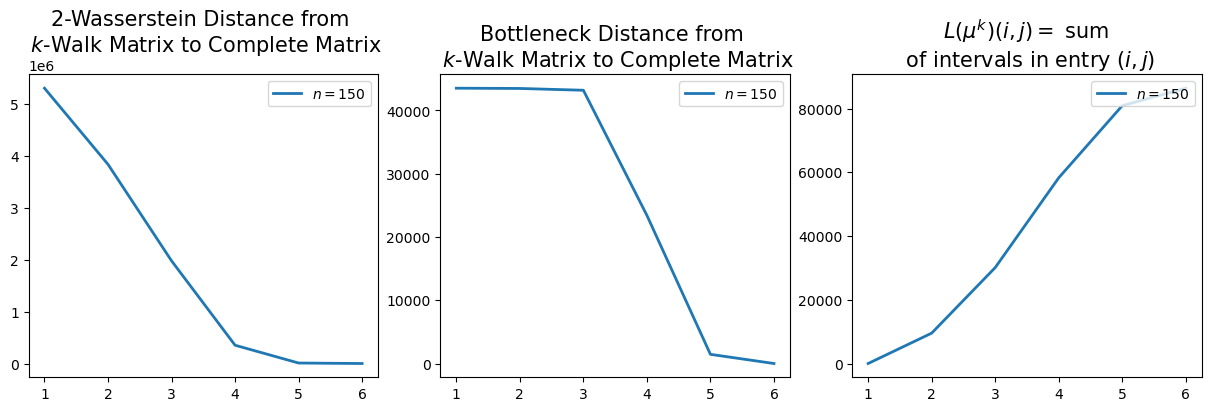

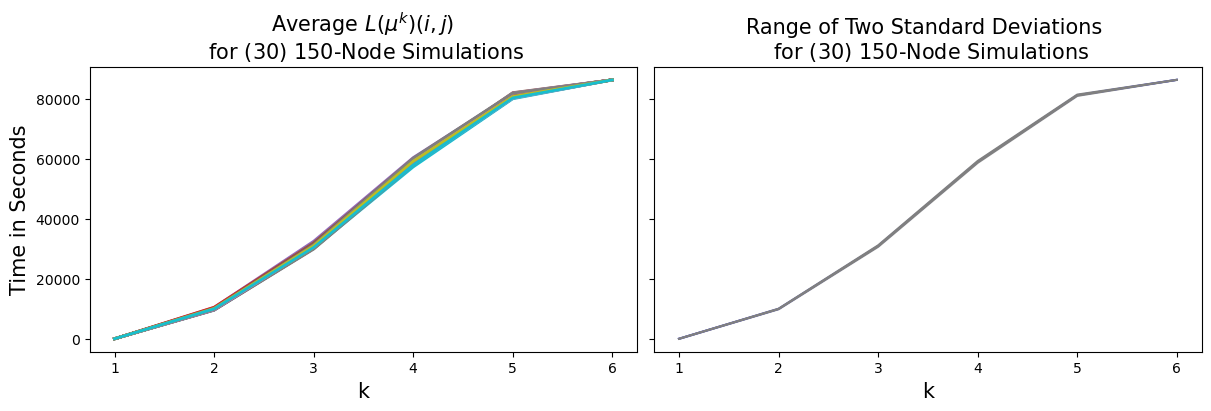

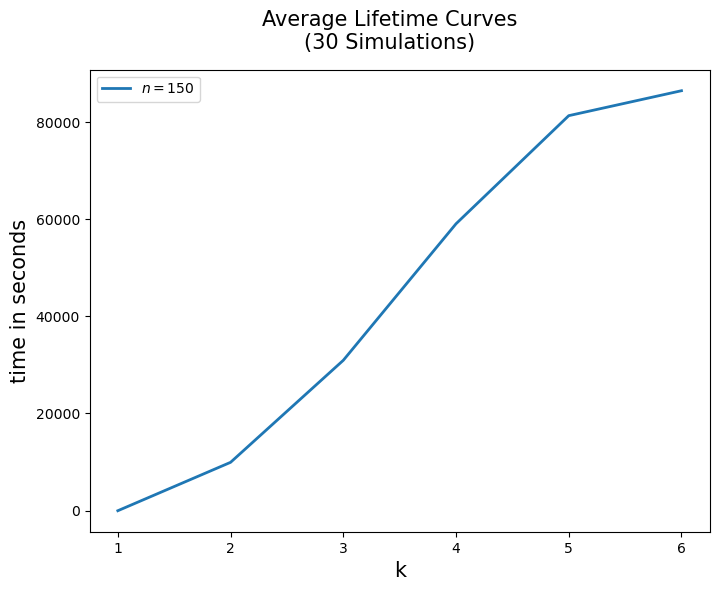

In [5]:
n_list = [20, 30, 40, 50, 70, 100] # Figure 5, 7
# n_list = [5, 10, 15, 20, 25, 30, 35, 40] # Figure 8
# n_list = [5, 10, 15, 20, 50]
n_list = [150]
simulation_count = 30
# simulation_count = 2

date = datetime.now()
print(f"Running Lifetime Matrix Simulations on Date = {date}")

print(f"Generating ORB Files")

folder_names = []
orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"lt-starlink-{n}-sat-single"
    folder_names.append(folder_name)
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y_%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

print(f"Constructing Matrices from ORB Files")
A = [[] for n in n_list]
B = [[] for n in n_list]
m = [[] for n in n_list] # dimensions of the matrices
max_diameter = [[] for n in n_list]
max_diameter_time = [[] for n in n_list]
max_diameter_sg = [[] for n in n_list]

diameters = [[] for n in n_list] # for histograms
sample_times = [[] for n in n_list] # for histograms

for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    # diagrams[i] = {}
    dim_sum = 0
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        filepath = path.replace(".orb", " Contact Analysis.csv")

        matrix = rp.soap_converter(filepath)
        A[i].append(matrix)
        B[i].append(IntervalMatrix.complete_matrix(matrix.dim_row))
        m[i].append(matrix.dim_row)

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        critical_times = rp.extract_critical_times(tvg)
        sample_times_ij = rp.sample_critical_times(critical_times)
        # sample_times_ij = sample_times_even
        # print(f"len(sample_times_ij)={len(sample_times_ij)} vs. {len(sample_times_even)}")

        diameter, time, sg, diameters_ij = sanx.get_max_diameter(tvg, sample_times_ij)

        max_diameter[i].append(diameter)
        max_diameter_time[i].append(time)
        max_diameter_sg[i].append(sg)

        sample_times[i].append(sample_times_ij)
        diameters[i].append(diameters_ij)

        # sanx.save_figure(sg, 
        #     f"{folder_base}/{folder_name}/{orb_filename}_max_graph_diameter.png")

        dim_sum += matrix.dim_row

    print(f"Average Dimension of {n}-Satellite TVG Matrices is {dim_sum / len(orb_paths[i])}")
    print(f"The maximum diameter over {len(orb_paths[i])} is {max(max_diameter[i])}")

print(f"Saving Histograms")

delta_time = 300
sample_times_even = list(range(0, 86400, delta_time))

for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    for j, path in enumerate(orb_paths[i]):
        orb_filename = path.replace(".orb", "").split("/")[-1]

        sample_times_ij = sample_times[i][j]
        diameters_ij = diameters[i][j]
        diameters_ij_even = [diameters_ij[find_nearest(sample_times_ij, t)] for t in sample_times_even]
        
        fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
        # fig.tight_layout(pad=10.0)

        # hist = axs[0].hist(diameters_ij)
        hist = axs[0].hist(diameters_ij_even)
        axs[0].set_xlabel("Slice Diameter")
        axs[0].set_ylabel("Slice Count")
        axs[0].set_title("Histogram of Diameters")

        axs[1].plot(sample_times_even, diameters_ij_even)
        axs[1].plot(sample_times_ij, diameters_ij)
        axs[1].set_xlabel("Slice Time (s)")
        axs[1].set_ylabel("Slice Diameter")
        axs[1].set_title("Graph of TVG Diameter")

        fig.suptitle(f"Diameters of {n}-Node System")

        plt.savefig(f"{folder_base}/{folder_name}/{orb_filename}_diameter_histogram.png")
        save_pgf_dat(f"{folder_base}/{folder_name}/{orb_filename}_diameter_histogram.dat", [diameters_ij])
        save_pgf_dat(f"{folder_base}/{folder_name}/{orb_filename}_diameter_histogram_even.dat", [diameters_ij_even])
        plt.close(fig)


print(f"Calculating Walks")

start_time, end_time = 0, 86400

walk_length = max([max(max_diameter[i]) for i in range(len(n_list))])
print(f"Calculating walks up to k = {walk_length}")

walks = [[] for n in n_list]

# for i, n in enumerate([]):
for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    
    print(f"Calculating Walks for {len(orb_paths[i])} {n}-Satellite Systems")
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        walks[i].append([IntervalMatrix.identity_matrix(m[i][j])])

        adjacency_matrices_max_diameter = []

        # print(f"Calculating Walks for {j}-th {n}-Satellite System")
        for k in range(walk_length):
            # print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
            if k == 0:
                A_k = A[i][j]
            else:
                A_k = A[i][j] * walks[i][j][-1]

            tvg_slice = A_k.get_slice_at(max_diameter_time[i][j])
            adjacency_matrices_max_diameter.append(np.array(tvg_slice))

            walks[i][j].append(A_k)

        filepath = f"{folder_base}/{folder_name}/{orb_filename}_heatmap.gif"
        if max_diameter[i][j] > 1:
            save_heatmap_gif(adjacency_matrices_max_diameter, m[i][j], max_diameter[i][j], filepath)


# Calculating Distances
print(f"Calculating Distances")
lifetime_list = [[] for n in n_list]
bdist = [None for n in n_list]
wdist_2 = [None for n in n_list]

for i, n in enumerate(n_list):
    bdist[i] = [None for j in orb_paths[i]]
    wdist_2[i] = [None for j in orb_paths[i]]

    for j, path in enumerate(tqdm(orb_paths[i])):
        bdist[i][j] = [-1 for k in range(1, walk_length)]
        wdist_2[i][j] = [-1 for k in range(1, walk_length)]

        # print(f"{i}:{j} : {path}")

        for k in range(1, walk_length):
            A_k = walks[i][j][k]
            B_k = B[i][j]
            # B_k = IntervalMatrix.complete_matrix(n)

            diagram_a_k = tvg_to_complement_diagram_matrix(A_k, start_time, end_time)
            diagram_b_k = tvg_to_complement_diagram_matrix(B_k, start_time, end_time)

            distance = tvg_interval_bottleneck_distance_matrix(diagram_a_k, diagram_b_k, m[i][j])
            bdist[i][j][k - 1] = sup_norm(distance)

            distance = tvg_interval_wasserstein_distance_matrix(diagram_a_k, diagram_b_k, m[i][j], 2)
            wdist_2[i][j][k - 1] = q_norm(distance, 2)

        # Lifetime Matrix
        L = tvg_lifetime_matrix(walks[i][j], start_time, end_time, walk_length)

        y_list = generate_y_list(L, walks[i][j][0].dim_row, walk_length)
        y_list_average = calculate_y_list_average(y_list, walk_length)
        lifetime_list[i].append(y_list_average)

# Plot Aggregates
print(f"Plotting Aggregates Overlay and Confidence Interval")

x = list(range(1, walk_length))

# Plot Wasserstein and Bottleneck Distances to Complete Matrices (First, j=0)
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
axs[0].set_title(f"2-Wasserstein Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[1].set_title(f"Bottleneck Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[2].set_title(f"$L(\mu^k)(i, j) = $ sum \n of intervals in entry $(i, j)$", fontsize=15)

for i, n in enumerate(n_list):
    distance = wdist_2[i][0]
    axs[0].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    distance = bdist[i][0]
    axs[1].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    coverage = lifetime_list[i][0][1:]
    axs[2].plot(x, coverage, linewidth=2, label=f"$n = {n}$")

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")

# tikzplotlib_fix_ncols(plt.gcf())
# tikzplotlib.save(f"{folder_base}/algebraic_distances_overlay_today_test.tex")
plt.savefig(f"{folder_base}/algebraic_distances_overlay_today_test.png")
save_pgf_dat(f"{folder_base}/bottleneck_distances_{n}_sats_today.dat", 
        [x] + [bdist[i][0] for i in range(len(n_list))]
        # ["k"] + [str(j) for j in range(len(orb_paths[i]))]
    )
save_pgf_dat(f"{folder_base}/wasserstein_distances_{n}_sats_today.dat", 
        [x] + [wdist_2[i][0] for i in range(len(n_list))]
        # ["k"] + [str(j) for j in range(len(orb_paths[i]))]
    )
plt.show()

# Plot Lifetime Distances and Confidence Intervals
mean_list = [[] for n in n_list]
for i, n in enumerate(n_list):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

    # axs[0].set_xlabel("k", fontsize=15)
    # axs[0].set_ylabel('Time in Seconds', fontsize=15)
    axs[0].set_title(f"Average $L(\mu^k)(i, j)$ \n for $({len(orb_paths[i])})$ ${n}$-Node Simulations", fontsize=15)

    # ax1.plot(x, lifetime_list[i][0][1:], linewidth=2) # plot first only
    for j, path in enumerate(orb_paths[i]):
        axs[0].plot(x, lifetime_list[i][j][1:], linewidth=2)
    # labels.append(f"$n = {n}$")

    lower_list = []
    upper_list = []

    for k in range(1, walk_length):
        data = []
        for j in range(1, len(lifetime_list[i])):
            data.append(lifetime_list[i][j][k])
        # mean, lower, upper = confidence_interval(data)
        mean, lower, upper = error_bars(data)
        
        mean_list[i].append(mean)
        lower_list.append(lower)
        upper_list.append(upper)

    # axs[1].set_xlabel("k", fontsize=15)
    # axs[1].set_ylabel("Time in Seconds", fontsize=15)
    axs[1].set_title(f"Range of Two Standard Deviations \n for $({len(orb_paths[i])})$ {n}-Node Simulations", fontsize=15)

    axs[1].plot(x, mean_list[i], color="blue")
    axs[1].plot(x, lower_list, color="grey")
    axs[1].plot(x, upper_list, color="grey")
    

    for ax in axs.flat:
        ax.set_xlabel("k", fontsize=15)
        ax.set_ylabel("Time in Seconds", fontsize=15)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.fill_between(x, lower_list, upper_list, color='grey', alpha=0.2)
    # tikzplotlib_fix_ncols(plt.gcf())
    # tikzplotlib.save(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.tex")
    plt.savefig(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.png")
    save_pgf_dat(f"{folder_base}/average_lifetime_curve_{n}_sats_today.dat", 
        [x] + [lifetime_list[i][j][1:] for j in range(len(orb_paths[i]))],
        ["x"] + [str(j) for j in range(len(orb_paths[i]))])
    save_pgf_dat(f"{folder_base}/range_sd_lifetime_matrix_{n}_sats.dat", 
        [x, mean_list[i], lower_list, upper_list], 
        ["x", "means", "lower", "upper"])
    plt.show()

labels = []
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("time in seconds", fontsize=15)
# fig.suptitle("Average 95% Confidence Interval Means", fontsize=15)
fig.suptitle(f"Average Lifetime Curves\n({simulation_count} Simulations)", fontsize=15)
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(x, mean_list[i], linewidth=2)
plt.legend(labels)

# tikzplotlib_fix_ncols(plt.gcf())
# tikzplotlib.save(f"{folder_base}/average_lifetime_matrix_aggregates_today.tex")
plt.savefig(f"{folder_base}/average_lifetime_matrix_aggregates_today_{simulation_count}.png")
save_pgf_dat(f"{folder_base}/average_lifetime_matrix_aggregates_today_{simulation_count}.dat", 
    [x] + [mean_list[i] for i in range(len(n_list))],
    ["x"] + [str(n) for n in n_list])
plt.show()

### KNN on Earth/Moon and Earth/Mars Simulations (Single Day)

Running KNN Simulations on Date = 2023-06-27 18:18:33.081961
Generating ORB Files
Running SOAP on ORB files


31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)


Average Points in Dgm[1] is 180.73333333333332
Average Points in Dgm[1] is 402.03333333333336
Average Points in Dgm[1] is 669.8666666666667
Average Points in Dgm[1] is 1386.4333333333334
Average Points in Dgm[1] is 3866.0333333333333
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [14:54<00:00, 178.88s/it]

Calculating Accuracies Single 80:20 Split for each `n`


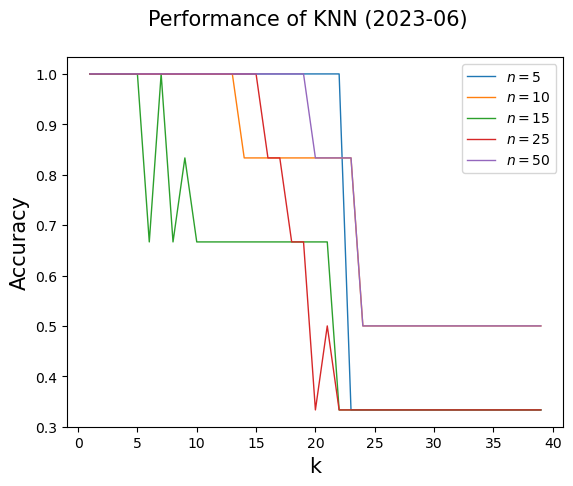

Calculating Accuracies 100 80:20 Splits for each `n`


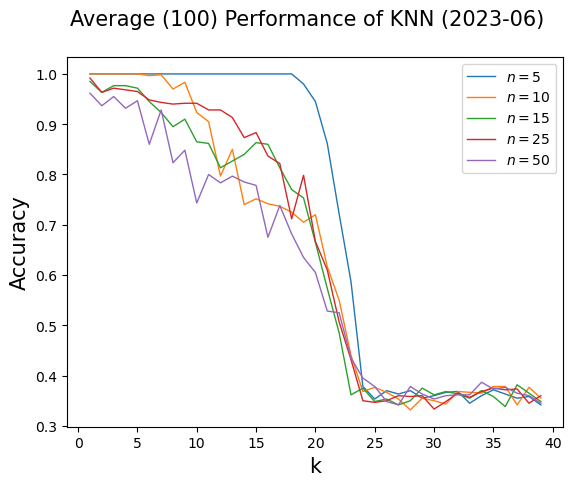

In [5]:
n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
simulation_count = 15 # number of simulations to run for each `n`
# simulation_count = 5

date = datetime.now()
print(f"Running KNN Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth / Moon Simulations
    for j in range(simulation_count):
        name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n) + moon_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

    # Generate Earth / Mars Simulations
    for j in range(simulation_count):
        name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n) + mars_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

# for path in orb_paths_flat:
#     print(path)

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_today.png")
save_pgf_dat(f"{folder_base}/knn_single_overlay_today_{simulation_count}_h{dim}.dat", 
    [ks] + [accuracies[i] for i in range(len(n_list))],
    ["x"] + [str(n) for n in n_list])
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_today.png")
save_pgf_dat( 
    f"{folder_base}/knn_single_overlay_average_{simulation_count}_h{dim}.dat", 
    [ks] + [accuracies[i] for i in range(len(n_list))],
    ["x"] + [str(n) for n in n_list])
plt.show()

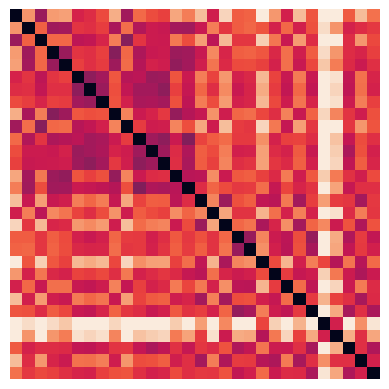

In [8]:
import seaborn as sns
for i in range(len(n_list)):
    filename = f"distance_matrix_{simulation_count}_{n_list[i]}_h{dim}"
    matrix = distance_matrix(distance_matrix_functions[i], diagrams[i], x[i])

    # print(distance_matrix_functions[i])
    mmax = np.max(matrix)
    plot = sns.heatmap(matrix / mmax, vmax=.8, square=True, cbar=False, xticklabels=False, yticklabels=False)
    fig = plot.get_figure()
    fig.savefig(f"{filename}.png") 

    content = ""
    nmatrix = (matrix / mmax).tolist()
    # content = "\\begin{table}[ht]\n"
    # content += "\\begin{center}\n"
    content += "\\begin{tabular}{*{" + str(len(nmatrix)) + "}{R}}\n"

    str_rows = []
    for row in nmatrix:
        # content += ",".join(["{:.2f}".format(entry) for entry in row]) + "\n"
        # content += " ".join([str(entry) for entry in row]) + "\n"
        str_rows.append(" & ".join(["{:.2f}".format(entry) for entry in row]))
        # content += " & ".join(["{:.2f}".format(entry) for entry in row]) + "\\\\\n"
    content += " \\\\\n".join(str_rows) + "\n"

    content += "\\end{tabular}\n"
    # content += "\\end{center}\n"
    # content += "\\end{table}"

    with open(f"./outputs/experiments/{filename}.table", "w") as file:
        file.write(content)


### KNN on Earth/Moon and Earth/Mars Simulations (Two year Periods)

24
Running KNN Simulations for Year = 2024
Generating ORB Files
Running SOAP on 240 ORB files


57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to f

Average Points in Dgm[1] is 177.60416666666666
Average Points in Dgm[1] is 383.8333333333333
Average Points in Dgm[1] is 653.8333333333334
Average Points in Dgm[1] is 1328.9791666666667
Average Points in Dgm[1] is 3751.1666666666665
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [57:21<00:00, 688.21s/it] 


Calculating Accuracies Single 80:20 Split for each `n`


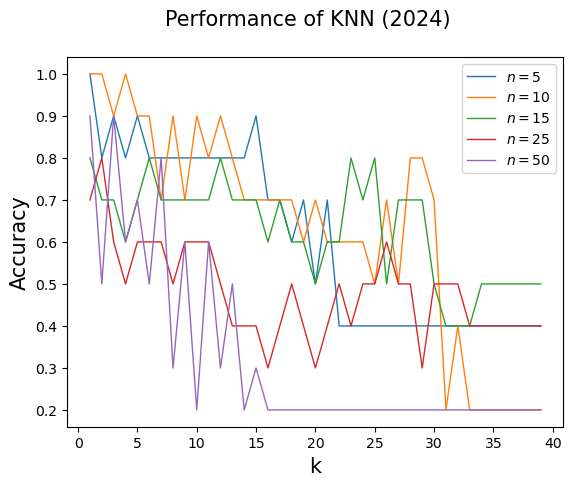

Calculating Accuracies 100 80:20 Splits for each `n`


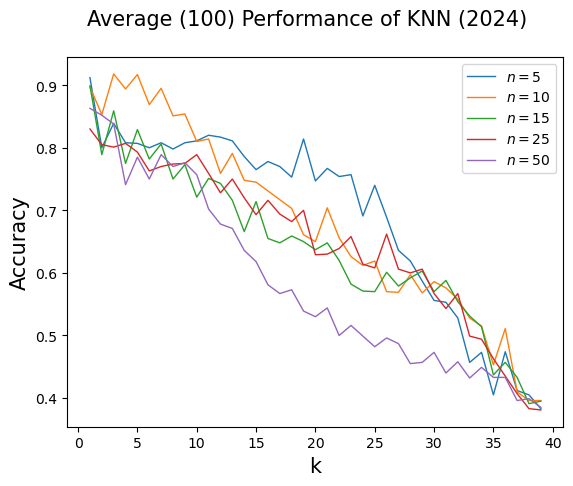

In [14]:
# n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
n_list = [5, 10, 15, 25, 50]
# simulation_count = 50 # number of simulations to run for each `n`
simulation_count = 1

year = 2024
months = 24
dates = []
for month in range(months):
    date = datetime(year + int(month / 12), month % 12 + 1, 1)
    dates.append(date)

print(len(dates))

# date = datetime.now()
print(f"Running KNN Simulations for Year = {year}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}-{year}"
    make_folder(f"{folder_base}/{folder_name}")

    for date in dates:
        starlink_sats = filter_starlink(date, starlink)

        # Generate Earth / Moon Simulations
        for j in range(simulation_count):
            name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
            orb_filename = generate_orb_files(
                folder_name, 
                name, 
                sample_sats(starlink_sats, n) + moon_sats,
                date)

            orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
            orb_paths[i].append(orb_path)

        # Generate Earth / Mars Simulations
        for j in range(simulation_count):
            name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
            orb_filename = generate_orb_files(
                folder_name, 
                name, 
                sample_sats(starlink_sats, n) + mars_sats,
                date)

            orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
            orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print(f"Running SOAP on {len(orb_paths_flat)} ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({year})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_{year}.png")
save_pgf_dat(f"{folder_base}/knn_single_overlay_{year}_{simulation_count}_h{dim}.dat", 
    [ks] + [accuracies[i] for i in range(len(n_list))],
    ["x"] + [str(n) for n in n_list])
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({year})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_{year}.png")
save_pgf_dat( 
    f"{folder_base}/knn_single_overlay_average_{year}_{simulation_count}_h{dim}.dat", 
    [ks] + [accuracies[i] for i in range(len(n_list))],
    ["x"] + [str(n) for n in n_list])
plt.show()

### Slice Analysis

In [31]:
n_list = [50]
simulation_count = 30

date = datetime.now()
print(f"Running Slice Analysis Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"slice-starlink-{n}-sat-single"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

# critical_times = [None for n in n_list]
for i, n in enumerate(n_list):

    # critical_times[i] = [None for j in orb_paths[i]]
    for j, path in enumerate(orb_paths[i]):

        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        # critical_times[i][j] = rp.extract_critical_times(graph)
        critical_times = rp.extract_critical_times(tvg)
        sample_times = rp.sample_critical_times(critical_times)

        diameters = []
        for time in sample_times:
            graph = sanx.get_graph_slice_at(tvg, time)
            diameters.append(sanx.get_diameter(graph))
            
        # print(f"NX : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")
        print(f"NX : {n}-sats-{j} : max={max(diameters)} (out of {len(sample_times)} slices)")

        diameters = []
        for time in sample_times:
            graph = sagt.get_graph_slice_at(tvg, time)
            diameters.append(sagt.get_diameter(graph))

        # print(f"GT : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")



Running Slice Analysis Simulations on Date = 2023-04-05 20:56:44.456107
Generating ORB Files
Running SOAP on ORB files
NX : 50-sats-0 : max=5 (out of 5012 slices)
NX : 50-sats-1 : max=7 (out of 5214 slices)
NX : 50-sats-2 : max=18 (out of 4282 slices)
NX : 50-sats-3 : max=5 (out of 5530 slices)
NX : 50-sats-4 : max=14 (out of 5533 slices)
NX : 50-sats-5 : max=9 (out of 5224 slices)
NX : 50-sats-6 : max=7 (out of 4701 slices)
NX : 50-sats-7 : max=14 (out of 5078 slices)
NX : 50-sats-8 : max=12 (out of 5173 slices)
NX : 50-sats-9 : max=9 (out of 5703 slices)
NX : 50-sats-10 : max=15 (out of 4754 slices)
NX : 50-sats-11 : max=7 (out of 4919 slices)
NX : 50-sats-12 : max=8 (out of 6004 slices)
NX : 50-sats-13 : max=20 (out of 4787 slices)
NX : 50-sats-14 : max=11 (out of 4748 slices)
NX : 50-sats-15 : max=10 (out of 4528 slices)
NX : 50-sats-16 : max=11 (out of 4808 slices)
NX : 50-sats-17 : max=6 (out of 5301 slices)
NX : 50-sats-18 : max=7 (out of 4138 slices)
NX : 50-sats-19 : max=9 (ou